🌟 **Exercises XP**

**Part 1 : Data Import and Initial Exploration**

In [1]:
# Import the necessary libraries for data analysis and visualization.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the time-series dataset from the provided file.
hpc = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)

# Display the first few rows of the dataset to understand its structure.
print(hpc.head())
print("----------------------------------------------------------------")

# Check the data types of each column and the shape of the dataset.
print("\n", hpc.info())

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  
----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entrie

**Part 2 : Handling Missing Values**

In [2]:
## Create a copy
df = hpc.copy()

## Print the shape of the dataframe
print(df.shape)

## Replace the missing values '?' with 'NaN' (reconize)
df.replace('?', np.nan, inplace=True)

# Identify columns in the dataset that contain missing values.
print(df.isnull().sum())

# Fill the missing values using the mean of the respective columns.
num_cols = df.columns[2:]
df[num_cols] = df[num_cols].astype(float)
df.fillna(df.mean(numeric_only=True), inplace=True)

## Drop the unique colum where the Time is missing
df.dropna(subset=['Time'], inplace=True)

# Verify that there are no more missing values in the dataset.
print("----------------------------------------------------------------")
print(df.isnull().sum())


(2075259, 9)
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
----------------------------------------------------------------
Date                     0
Time                     0
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


**Part 3 : Data Visualization**

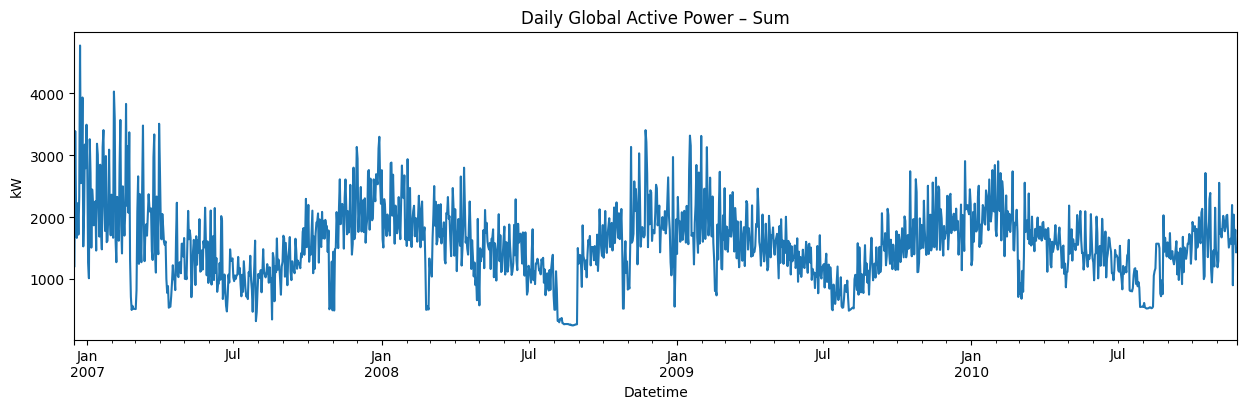

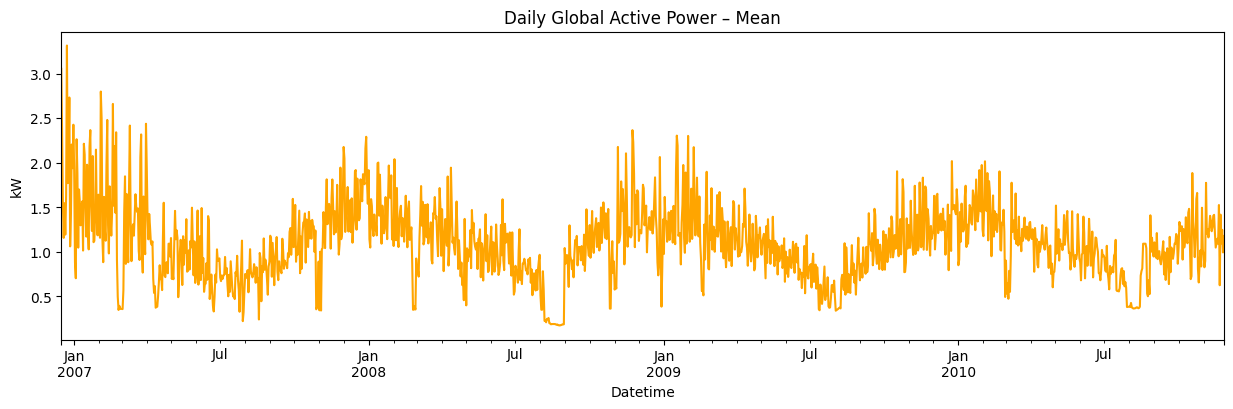

In [3]:
# Resample the ‘Global_active_power’ column over a day and plot the sum and mean values.
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df.set_index('Datetime', inplace=True)

## sum value
daily_sum = df['Global_active_power'].resample('D').sum()

## mean value
daily_mean = df['Global_active_power'].resample('D').mean()

# Create a plot showing the mean and standard deviation of the ‘Global_intensity’ column resampled over a day.
plt.figure(figsize=(15, 4))
daily_sum.plot(title='Daily Global Active Power – Sum')
plt.ylabel('kW')
plt.show()

plt.figure(figsize=(15, 4))
daily_mean.plot(title='Daily Global Active Power – Mean', color='orange')
plt.ylabel('kW')
plt.show()


**Part 4 : Data Preprocessing for LSTM**

In [7]:
from sklearn.preprocessing import MinMaxScaler

## Define the target column for prediction (univariate approach)
target_col = 'Global_active_power'

# Normalize the dataset to prepare it for LSTM model training.
numerical_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                  'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

## Initialise the scaler
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(df[numerical_cols])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols, index=df.index)

# Split the dataset into training and testing sets. (80/20 split)
X_train = scaled_df.iloc[:int(0.8 * len(scaled_df))]
X_test = scaled_df.iloc[int(0.8 * len(scaled_df)):]

# Select only the target variable and reshape
training_data = X_train[target_col].values  # shape: (n,)
training_data = training_data.reshape(-1, 1)


# Create sequences of 60 timesteps
X_train_seq = []
y_train_seq = []
SEQ_LENGTH = 60

for i in range(SEQ_LENGTH, len(training_data)):
    X_train_seq.append(training_data[i-SEQ_LENGTH:i, 0])
    y_train_seq.append(training_data[i, 0])

X_train_seq = np.array(X_train_seq)
y_train_seq = np.array(y_train_seq)

# Reshape the data to fit the input requirements of an LSTM model.(samples, timesteps, features)
X_train_seq = np.reshape(X_train_seq, (X_train_seq.shape[0], X_train_seq.shape[1], 1))

### We do the same for the test: ###
test_data = X_test[target_col].values.reshape(-1, 1)

X_test_seq = []
y_test_seq = []

for i in range(SEQ_LENGTH, len(test_data)):
    X_test_seq.append(test_data[i-SEQ_LENGTH:i, 0])
    y_test_seq.append(test_data[i, 0])

X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

X_test_seq = np.reshape(X_test_seq, (X_test_seq.shape[0], X_test_seq.shape[1], 1))


**Part 5 : Building an LSTM Model**

In [8]:
# Import the necessary libraries for building an LSTM model.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the architecture of the LSTM model, including the number of layers and neurons.
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

# Compile the model with an appropriate loss function and optimizer.
model.compile(optimizer='rmsprop', loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Part 6 : Training and Evaluating the LSTM Model**

Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 22s 153ms/step - loss: 0.0026 - val_loss: 0.0076
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 144ms/step - loss: 0.0025 - val_loss: 0.0075
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - loss: 0.0026 - val_loss: 0.0076
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - loss: 0.0024 - val_loss: 0.0075
12969/12969 ━━━━━━━━━━━━━━━━━━━━ 387s 30ms/step - loss: 9.0950e-04
Test loss: 0.0009091388783417642


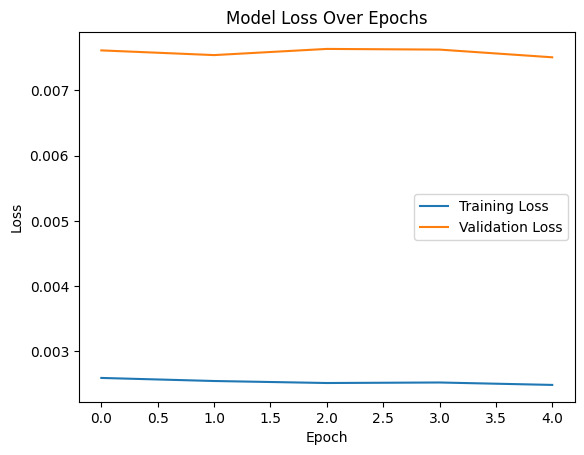

In [12]:
# Train the LSTM model on the training dataset.
X_train_seq_small = X_train_seq[:10000]
y_train_seq_small = y_train_seq[:10000]

history = model.fit(
    X_train_seq_small, y_train_seq_small,
    epochs=5,
    batch_size=64,
    validation_split=0.1
)


# Evaluate the model’s performance on the testing dataset.
test_loss = model.evaluate(X_test_seq, y_test_seq)
print("Test loss:", test_loss)

# Plot the training and validation loss to assess the model’s learning progress.
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()